###############################################################################################

# **Optical Vegetation Indices**

###############################################################################################

# 1. Introduction

Welcome to the first exercise on vegetation and drought monitoring. In this notebook you will learn how to work with raster files in Python and how to execute simple calculations. The goal is to calculate some usefull vegetation indices from optical satellite data. We will make use of top of canopy (TOC) reflectance values from the Sentinel-2 mission.

The data used in this exercise has already been downloaded for you and can be found in the /data folder. We will focus on a small region in the city of Antwerp, Belgium.

Notebook outline:

- [1. Introduction](#1.-Introduction)
- [2. Import libraries](#2.-Import-libraries)
- [3. Read Data](#3.-Read-Data)
- [4. Preprocessing](#4.-Preprocessing)
- [5. Vegetation Index Computation](#5.-Vegetation-Index-Computation)

# 2. Import libraries

Import all the modules needed for this exercise:

In [2]:
import os
import glob
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
import rioxarray

# 3. Read Data

In order to work with raster data (e.g., GeoTIFF files), we first need to convert them to numerical arrays. In this section we will import and prepare the data.

## 3.1 Import files

In [3]:
# With this cell you check all the available tif files in the input_folder
# define input_folder
input_folder = r'./data/S2A_20170526T105031_31UES_TOC'
# get list of tif files in the input_folder
input_fhs = sorted(glob.glob(input_folder+r'/*.tif')) 

input_fhs 

['./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B03_10m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B04_10m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B05_20m.tif',
 './data/S2A_20170526T105031_31UES_TOC/B08_10m.tif']

Using the rioxarray package, open the following bands: 
- B02 (blue)
- B03 (green)
- B04 (red)
- B05 (red-edge/reg)
- B08 (nir)

In [4]:
blue = rioxarray.open_rasterio(input_fhs[0])
green = rioxarray.open_rasterio(input_fhs[1])
red = rioxarray.open_rasterio(input_fhs[2])
reg = rioxarray.open_rasterio(input_fhs[3])
nir = rioxarray.open_rasterio(input_fhs[4])

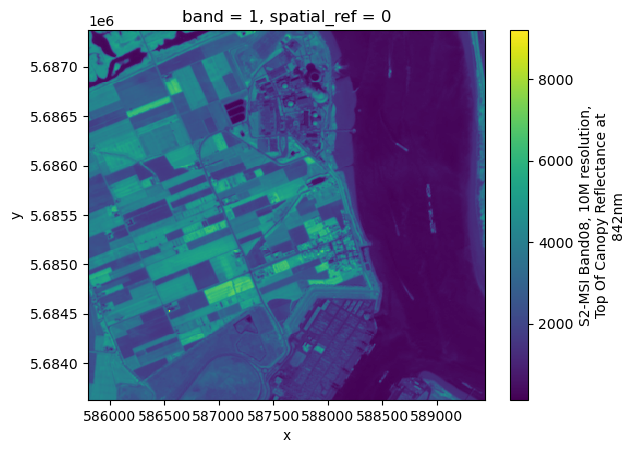

In [5]:
# rioxarray has built-in plotting functionality for fast plotting of the data...
nir.plot()
plt.show()

## 3.2 Metadata

Make sure to always check your meta data. Here you can find the properties and relevant information about your raster file, including size, nodata value, spatial reference, and scale factor. We will come back to the latter during pre-processing.

In [6]:
# you can get an overview of the dataset's contents by just printing the rioxarray object:
blue

<xarray.DataArray (band: 1, y: 374, x: 364)>
[136136 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.858e+05 5.858e+05 ... 5.894e+05 5.894e+05
  * y            (y) float64 5.687e+06 5.687e+06 ... 5.684e+06 5.684e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    32767.0
    scale_factor:  0.0001
    add_offset:    0.0
    long_name:     S2-MSI Band02, 10M resolution, Top Of Canopy Reflectance a...

In [7]:
# or: store the metadata in separate variables
nodata = blue._FillValue
scale = blue.scale_factor
nbands = blue.shape[0]
ysize = blue.shape[1]
xsize = blue.shape[2]
crs = blue.rio.crs

print(f'Nodata Value: {nodata}')
print(f'Scale factor: {scale}')
print(f'Coordinate reference system: {crs}')
print(f'Number of bands: {nbands}')
print(f'Xsize: {xsize}')
print(f'Ysize: {ysize}')

Nodata Value: 32767.0
Scale factor: 0.0001
Coordinate reference system: EPSG:32631
Number of bands: 1
Xsize: 364
Ysize: 374


QUESTION: check the metadata for each of the bands (.tiff files). Do you notice any differences between the bands?

# 4. Preprocessing

As you probably will have noticed in the metadata, not all images have the same size. The red edge band for example, has a resolution of 20m instead of 10m. In order to combine the two resolutions, the red edge data needs to be resampled to match the size of the other bands. Furthermore, sometimes we are only interested in a part of the area covered in the image. To improve computation efficiency, we can crop the data to only our region of interest. In addition, the data comes with a scale factor that needs to be applied before actual calculations can happen. 

These types of preprocessing can be easily executed with the GDAL package and will be covered in this section.

## 4.1 Resample 20m data to 10m data using *gdal.Warp*

If we want to do raster analysis or calculations, the rasters in questions need to match perfectly. For example the Red-Edge band has a resolution of 20m, whereas the other bands have a resolution of 10m. This can be done using the *gdal.Warp* function, an image mosaicing, reprojection and warping function. 

First, get info on the target/destination file and on the source file:

In [8]:
# destination info, which projection/resolution do we want? (here blue band)
dst_info = gdal.Info(gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B02_10m.tif'),format='json') 
# source info, the file we want to alter (here REG band)
src_info = gdal.Info(gdal.Open(r'./data/S2A_20170526T105031_31UES_TOC/B05_20m.tif'),format='json') 

After getting source *src_info* and target info *dst_info*, we can fill in this information to *gdal.Warp* as follows. The function will then resample the Red-Edge band raster data values to the same resolution as the blue band raster. If the *gdal.Warp* function finished successfully, it will return an *osgeo.gdal.Dataset* object and the output raster file will be saved in the output folder.

In [9]:
source_file = r'./data/S2A_20170526T105031_31UES_TOC/B05_20m.tif'
output_folder = r'./output'
#create output_folder if it does not exist
if not os.path.exists(output_folder): 
    os.makedirs(output_folder)

#get filename from source_file path    
filename = os.path.basename(source_file) 
#create an output file path
output_file = os.path.join(output_folder,
                           filename.replace('20m','10m')) 

output = gdal.Warp(output_file,source_file,format='GTiff',
              srcSRS=src_info['coordinateSystem']['wkt'],
              dstSRS=dst_info['coordinateSystem']['wkt'],
              srcNodata=src_info['bands'][0]['noDataValue'],
              dstNodata=dst_info['bands'][0]['noDataValue'],
              width=dst_info['size'][0],
              height=dst_info['size'][1],
              outputBounds=(dst_info['cornerCoordinates']['lowerLeft'][0],
                            dst_info['cornerCoordinates']['lowerLeft'][1],
                            dst_info['cornerCoordinates']['upperRight'][0],
                            dst_info['cornerCoordinates']['upperRight'][1]),
              outputBoundsSRS=dst_info['coordinateSystem']['wkt'],
              resampleAlg='near')
# (use the following line to make sure the output is written to disk correctly)
output = None

QUESTION: Now open the newly created file, check its dimensions, plot the image and compare to the original 20 m band data.

Tip: when plotting raster data, you can adjust the color scale range by using the vmin and vmax arguments directly in the plotting function.
For instance:
data.plot(vmin=0, vmax=5000) --> color scale is clipped to the [0, 5000] range

## 4.2 Crop raster to shapefile

As you will notice, some satellite products cover a large area. At high resolution (such as the data we're looking at) this takes a lot of storage and computational power to execute your analysis. Therefore, it is useful to crop your rasters to only your area of interest. This section will provide the necessary tools to execute this preprocessing step. 

In [10]:
# path to output folder
output_folder = r'./output/S2A_clipped'
# create output_folder if it does not exist
if not os.path.exists(output_folder): 
    os.makedirs(output_folder)
    
# path to the shapefile containing polygon of region of interest
shapefile = r"./data/Shapefile/RegionOfInterest.shp"

# loop over each band...
for input_fh in input_fhs:
    
    # in case of B05, make sure we use the 10m product!
    if 'B05' in input_fh:
        input_fh = './output/B05_10m.tif'
        
    # get filename from source_file path
    filename = os.path.basename(input_fh)

    # create an output file path
    output_fh = os.path.join(output_folder, filename[:-4] + '_crop.tif') 
    sourceds = gdal.Warp(output_fh, 
                         gdal.Open(input_fh), 
                         cutlineDSName=shapefile,
                         cropToCutline=True, 
                         dstNodata=32767)
    # (use the following line to make sure the output is written to disk correctly)
    sourceds = None

Below an example of how the output looks like after clipping.
Note that if you want the nodata value to appear white in the plot, you have to convert
the nodata values to NaN.

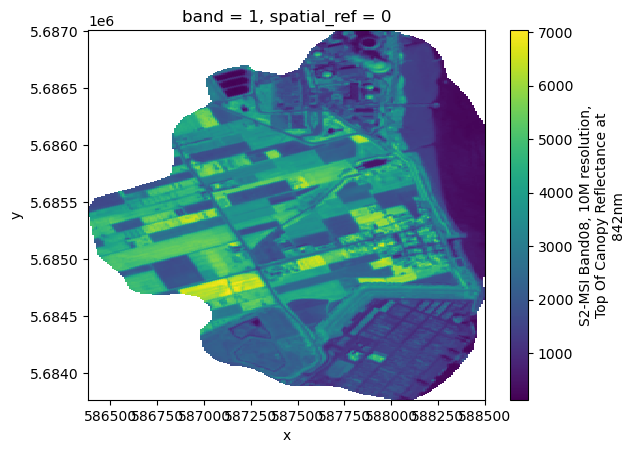

In [11]:
output = rioxarray.open_rasterio(output_fh)
# only retain values not equal to the nodata value
output_masked = output.where(output != nodata)
output_masked.plot()
plt.show()

## 4.3 Applying the scale factor

Before diving into raster computations, we need to look at the scale factor again. As you noted in the plots above, the reflectance values are stored as Integer numbers in order to limit the size of the files. Reflectances however range between 0 and 1. To actually get the real physical reflectance value, we need to apply the scale factor which is documented in the metadata.
Below, we first set all no data to NaN and then apply the scale factor as a simple multiplication.

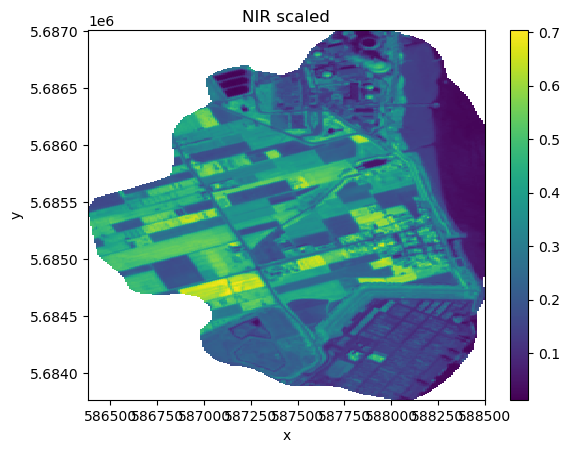

In [12]:
# we start from the clipped bands and loop over them all, storing the results in a list:
reflectances = []
# get all input files
infiles = sorted(glob.glob(os.path.join(output_folder, '*.tif')))
for infile in infiles:
    data = rioxarray.open_rasterio(infile)
    data = data.where(data != nodata)
    data = data * scale
    reflectances.append(data)
    
# plot the NIR band:
reflectances[-1].plot()
plt.title('NIR scaled')
plt.show()

# 5. Vegetation Index Computation

## 5.1 NDVI

Now let's have a look at some vegetation indices. First we will calculate the NDVI by selecting the right bands from our stack of arrays. As you can recall from the lectures, its formula is the following:

$$
NDVI = \frac{NIR - RED}{NIR + RED}
$$

In [13]:
nir = reflectances[-1]
red = reflectances[2]
ndvi = (nir - red)/(nir + red)

QUESTION: Plot the NDVI. How can you interpret the map, where are the high and low NDVI values and with what landcover do they belong?

For exporting our computed index (for instance for visually inspecting the product in QGIS), we simply make use of rioxarray's rio.to_raster functionality:

In [14]:
outfile = './output/NDVI.tif'
ndvi.rio.to_raster(outfile)

## 5.2 Other Vegetation Indices

Now try to calculate the vegetation indices below:

_Enhanced Vegetation Index (EVI):_
$$
EVI = 2.5*\frac{NIR - RED}{(NIR+6*RED - 7.5*BLUE) + 1}
$$
_Normalized Difference Red Edge Index (NDRE):_
$$
NDRE = \frac{NIR - REG}{NIR + REG}
$$

More vegetation indices can be found on the Index DataBase website: https://www.indexdatabase.de/